In [2]:
cd C:\Users\sriha\Desktop\Machine Learning Engineer\p13-takehome-ml

C:\Users\sriha\Desktop\Machine Learning Engineer\p13-takehome-ml


### Import libraries 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as py
import seaborn as sns

### Import "click-through" dataset

In [4]:
data = pd.read_csv("sampled_training.csv")

#### Sneak peak into the dataset

In [5]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10002028568167339219,0,14102100,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,...,1,2,20596,320,50,2161,0,35,100148,157
1,10006958186789044052,1,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,1,0,18993,320,50,2161,0,35,100034,157
2,10011650513707909570,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,1,0,21611,320,50,2480,3,297,100111,61
3,10022961149355219548,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,100148,32
4,10029289556764215760,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,100084,79


### Data Description

Training dataset has 843502 instances with 24 data fields.


### Dataset Fields

* id: ad identifier
* click: 0/1 for non-click/click
* hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* C1 — anonymized categorical variable
* banner_pos
* site_id
* site_domain
* site_category
* app_id
* app_domain
* app_category
* device_id
* device_ip
* device_model
* device_type
* device_conn_type
* C14-C21 — anonymized categorical variables

## Exploratory data analysis and  Feature engineering

Checking the click through rate behaviour for better understanding.

The click through rate is approximately 17.027% (Number of Ad clicks / Total number of instances) 

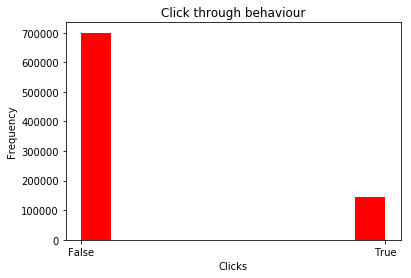

In [9]:
py.hist(data.click,color="red")
py.xlabel("Clicks")
py.ylabel("Frequency")
py.xticks(range(0, 2),['False','True'])
py.title('Click through behaviour')
py.show()

##### Removing "id" feature as it doesnt add any significance to the prediction model

In [10]:
data = data.drop(["id"],axis=1)

###### Analyzing C1 feature

C1 is a anonimized categorical variable and most of the values fall under the category of 1005.

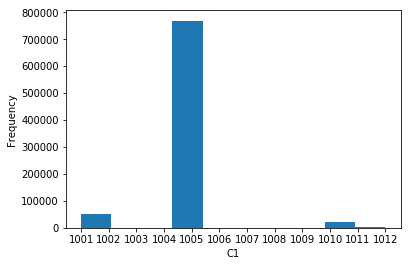

In [19]:
py.hist(data.C1,label=data.C1.unique().astype(str))
py.xlabel("C1")
py.ylabel("Frequency")
py.xticks(range(1001, 1013))
py.show()

###### Percentage of data poitns under category 1005

91.11% of values fall under "1005" category.

In [17]:
data.groupby("C1").size()/data.shape[0]*100

C1
1001     0.032365
1002     6.041242
1005    91.112054
1007     0.098399
1008     0.019443
1010     2.461049
1012     0.235447
dtype: float64

##### Analyzing banner positions

There are 7 banner positions, which implies the positions where the banner ads are posted. We can see that most of the ad clicks happen when the banner is in positions 1 and 2.

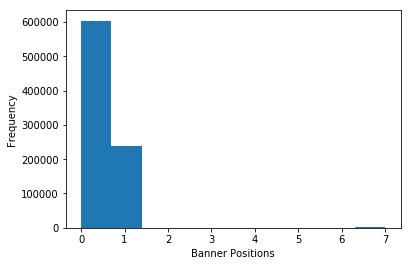

In [20]:
py.hist(data.banner_pos)
py.xlabel("Banner Positions")
py.ylabel("Frequency")
py.show()

###### CTR analysis of banner position

Belowe we see the percentage of CTR for position 1 to 7 respectively. The highest CTR is seen for banner position 7.

In [40]:
# CTR calculation by using number of clicks / total instances 
clicks = data[['banner_pos','click']].groupby(['banner_pos']).sum().reset_index().sort_values('click',ascending=False)['click']
banner_pos = data[['banner_pos','click']].groupby(['banner_pos']).sum().reset_index().sort_values('click',ascending=False)['banner_pos']
instances = data[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']
CTR = (clicks/instances)*100

In [41]:
pd.concat([pd.DataFrame(banner_pos), pd.DataFrame(CTR)], axis=1)

,banner_pos,click
0,0,16.354514
1,1,18.688072
6,7,29.873909
2,2,10.320285
4,4,15.083799
5,5,16.463415
3,3,11.864407


##### Analyzing app categories and sites

Evidently there are about 28 app categories and 2366 unique site categories in the given dataset.

### Feature engineering hour attribute

The "hour" feature in the dataset is of the format YYMMDDHH. In order to better analyze the data, I am splitting the feaure into "Date", "Month", "Year" and "Hour". The given dataset is for year 2014 and "October" Month, which is constant and does not add any value to the prediction model and hence removing those features below.

In [42]:
import re
data['Year'], data['Month'], data['Date'], data['Hour'] = np.array([data.hour.apply(lambda x : re.findall('..',str(x)))]).T

In [50]:
data = data.drop(["hour","Month","Year"],axis=1)

##### Analyzing number of clicks per day in october 2014

On 22 and 24th we see most ad clicks. Let us see how this translates in CTR?

Text(0,0.5,'Number of clicks')

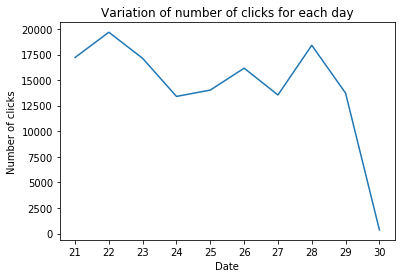

In [51]:
py.plot(data.Date.unique(),data[['Date','click']].groupby(['Date']).sum())
py.title("Variation of number of clicks for each day")
py.xlabel("Date")
py.ylabel("Number of clicks")

##### Analyzing number of clicks per hour in october 2014

At 1 pm, we see most ad clicks.

Text(0,0.5,'Number of clicks')

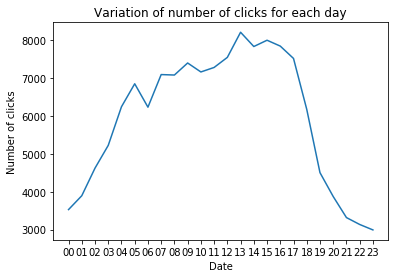

In [55]:
py.plot(data.Hour.unique(),data[['Hour','click']].groupby(['Hour']).sum())
py.title("Variation of number of clicks for each day")
py.xlabel("Date")
py.ylabel("Number of clicks")

## Pre-processing 

##### Converting "Banner position", "Device type" and "device connection type" from numerical value to categorical

In [56]:
data.banner_pos = data.banner_pos.astype(str)
data.device_type = data.device_type.astype(str)
data.device_conn_type = data.device_conn_type.astype(str)

##### Extracting target variable and other preditors into a data frame

In [57]:
target = data.click
data = data.iloc[:,1:]

##### Check for near zero variance variables

This is to make sure that we do not have any redudant or constant variable as it does not provide any new information to the model in turn would not help with our models prediction capability.

We are looking for variables with variace of 0.1 % or less to be removed.

In [58]:
data[data.describe().columns.values].shape

(843502, 9)

In [59]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
data1 = selector.fit_transform(data[data.describe().columns.values])

In [60]:
data1.shape

(843502, 9)

As we have the same size after checking for NZV with a threshold of 0.1 %, we do not have to remove any variables from the dataset.

##### Correlation check or collinearity check

Having highly correlated variables would highly affect the predictive model and also if two variables have very high correlation (i.e 0.8 or higher), then one of the variable can be removed as two variables with same information adds redundancy and unnecsarry complexity

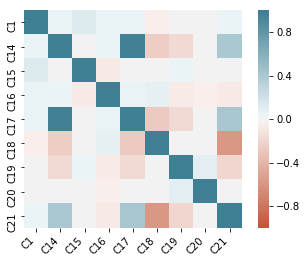

In [61]:
corr = data[data.describe().columns.values].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From the above plot, we can see that C14 and C17 are highly correlated and we can remove one of the variable, which I have chosen to be "C14"

In [62]:
data = data.drop("C14",axis=1)

##### Scaling

Scaling plays a vital part in better performance and reduction in compute power of the predictive model. Hence, we would scale the numerical data using "Min Max Scaler", this makes all the numerical values between similar range. The added advantage is that we see smaller numerical values in some features and very large values in other, this causes confusion to the ML model and might produce wrong results.

In [63]:
from sklearn.preprocessing import MinMaxScaler

colnames = data.describe().columns.values
scaler = MinMaxScaler()
scaler.fit(data._get_numeric_data())
data[colnames] = scaler.transform(data._get_numeric_data())

C:\Users\sriha\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##### Label Encoding

The categorical variables cant be passed as inputs to a Machine learning model (as these are mathematical models). We need to convert the categorical variable into numerical classes. This can be acheived using "label encoding" where each class is provided a numerical value from 0 to "number of classes". I have opted for label encoding rather than one-hot encoding as we have large number of categories and creating a separte feature for each category would means huge number of classes which clearly increases complexity and overfits the model a lot.

In [64]:
from sklearn.preprocessing import LabelEncoder

colnames1 = data.select_dtypes(include='object').columns.values
data[colnames1] = data.select_dtypes(include='object').apply(LabelEncoder().fit_transform)

### Handling Imbalance data

This is very important to handle imbalanced data as it greatly biases the predictive models and produces good accuracy values but very poor precision and recall, which implies a very bad model for real world usage.

In this case, there is a clear imbalance between the ads clicked and not clicked by a large margin or 1:7. This makes the model biased towards ads not clicked. The model would most of the time predict as ad being not clicked but in reality it might have been clicked but model fails to detect due to very small number of ad clicks information.

##### Here I have opted for the over-sampling approach using ADASYN (Adaptive Synthetic Sampling Approach). This over samples the class with small number of instances to make the dataset balanced. 

Below histograms would show this.

#### I have also built ML models with both imbalanced and balanced dataset to show the difference

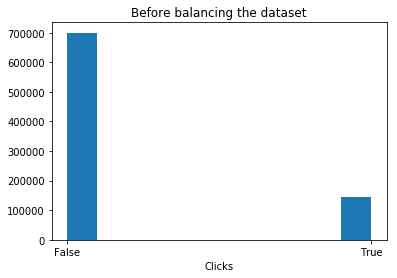

In [66]:
py.hist(target)
py.title("Before balancing the dataset")
py.xticks(range(0,2),['False','True'])
py.xlabel("Clicks")
py.show()

In [67]:
target1 = target
data1 = data

from imblearn.over_sampling import ADASYN 
sm = ADASYN(random_state=42)
data, target = sm.fit_sample(data, target)

We can see below that the number of instances have increased from 843502 to 1392962 instances.

In [70]:
data.shape

(1392962, 22)

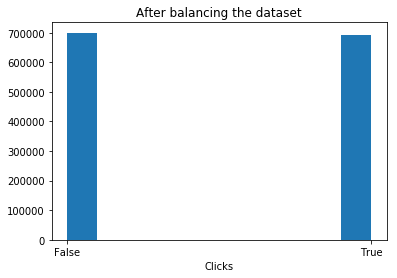

In [69]:
py.hist(target)
py.title("After balancing the dataset")
py.xticks(range(0,2),['False','True'])
py.xlabel("Clicks")
py.show()

## Model Building

#### Splitting data into test and train datasets

80% training and 20% validation dataset 

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, target1, test_size=0.2, random_state=42)

#### When it comes to classification, using accuracy blindly as the performance metric would be a disaster, better metrics such as precision or F1 score and ROC curve should be used for better reliable performance metric. Hence, here I am using accuracy and F1-score. Also I have shown how this the above statement is true in imbalanced classes.

### Naive Bayes - Without imbalance correction

In [80]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

gnb1 = GaussianNB()
NBpred1 = gnb1.fit(X_train1,y_train1).predict(X_test1)
print("Accuracy (%):")
print(gnb1.score(X_test1, y_test1)*100)

print("\n\nConfusion Matrix:")
print(confusion_matrix(y_test1, NBpred1))
print("\nClassification Report:")
print(classification_report(y_test1, NBpred1))

print("F1 Score:")
print(f1_score(y_test1, NBpred1))

Accuracy (%):
83.05167130011085


Confusion Matrix:
[[140104      9]
 [ 28583      5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91    140113
           1       0.36      0.00      0.00     28588

   micro avg       0.83      0.83      0.83    168701
   macro avg       0.59      0.50      0.45    168701
weighted avg       0.75      0.83      0.75    168701

F1 Score:
0.00034962590028669323


### Naive Bayes - With imbalance correction

In [76]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

gnb = GaussianNB()
NBpred = gnb.fit(X_train,y_train).predict(X_test)
print("Accuracy (%):")
print(gnb.score(X_test, y_test)*100)

print("\n\nConfusion Matrix:")
print(confusion_matrix(y_test, NBpred))
print("\nClassification Report:")
print(classification_report(y_test, NBpred))

print("F1 Score:")
print(f1_score(y_test, NBpred))

Accuracy (%):
55.08573438672185


Confusion Matrix:
[[ 43434  96737]
 [ 28391 110031]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.31      0.41    140171
           1       0.53      0.79      0.64    138422

   micro avg       0.55      0.55      0.55    278593
   macro avg       0.57      0.55      0.52    278593
weighted avg       0.57      0.55      0.52    278593

F1 Score:
0.6375097772241375


#### Taking naive bayes algorithm, we can see that without imbalance correction the accuracy is 83% which seems great but looking at F1 score, it is evident that the model is a disaster (i.e the model is highly influenced by majority class and undermines the minority class) and would be the worst model to use in real life scenario.

#### Whereas the corrected model has lower accuract of 55 % but the F1 score is very much significant indicating an un-biased and treu to life model.

#### This is the case with all the upcoming models, Hence I would show the difference again with the best model.

## Logistic Regression - With imbalance correction

In [77]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression().fit(X_train,y_train)
logisticPred = clf1.predict(X_test)
print("Accuracy (%):")
print(clf1.score(X_test, y_test)*100)

print("\n\nConfusion Matrix:")
print(confusion_matrix(y_test, logisticPred))
print("\nClassification Report:")
print(classification_report(y_test, logisticPred))

print("F1 Score:")
print(f1_score(y_test, logisticPred))

C:\Users\sriha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy (%):
58.281794589239496


Confusion Matrix:
[[75751 64420]
 [51804 86618]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.54      0.57    140171
           1       0.57      0.63      0.60    138422

   micro avg       0.58      0.58      0.58    278593
   macro avg       0.58      0.58      0.58    278593
weighted avg       0.58      0.58      0.58    278593

F1 Score:
0.5984799281420577


## xgboost algorithm with 100 estimators - With Correction

In [81]:
import xgboost as xgb

clf6 = xgb.XGBClassifier(n_estimators=100)
clf6.fit(X_train, y_train)
xgBoostPred = clf6.predict(X_test)
print("Accuracy (%):")
print(clf6.score(X_test, y_test)*100)

print("\n\nConfusion Matrix:")
print(confusion_matrix(y_test, xgBoostPred))
print("\nClassification Report:")
print(classification_report(y_test, xgBoostPred))

print("F1 Score:")
print(f1_score(y_test, xgBoostPred))

Accuracy (%):
82.89906781577426


Confusion Matrix:
[[134432   5739]
 [ 41903  96519]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85    140171
           1       0.94      0.70      0.80    138422

   micro avg       0.83      0.83      0.83    278593
   macro avg       0.85      0.83      0.83    278593
weighted avg       0.85      0.83      0.83    278593

F1 Score:
0.8020525178660461


## Random Forest algorithm - With Imbalance Correction

In [82]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(X_train, y_train)  

randForestPred = clf.predict(X_test)
print("Accuracy (%):")
print(clf.score(X_test, y_test)*100)

print("\n\nConfusion Matrix:")
print(confusion_matrix(y_test, randForestPred))
print("\nClassification Report:")
print(classification_report(y_test, randForestPred))

print("F1 Score:")
print(f1_score(y_test, randForestPred))

Accuracy (%):
88.11456138524659


Confusion Matrix:
[[127052  13119]
 [ 19993 118429]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88    140171
           1       0.90      0.86      0.88    138422

   micro avg       0.88      0.88      0.88    278593
   macro avg       0.88      0.88      0.88    278593
weighted avg       0.88      0.88      0.88    278593

F1 Score:
0.8773493351113086


## Decision Tree algorithm - Without Imbalance Correction

In [84]:
from sklearn.tree import DecisionTreeClassifier
dtree1=DecisionTreeClassifier()
dtree1.fit(X_train1, y_train1)

decisionTreePred1 = dtree1.predict(X_test1)
print("Accuracy (%):")
print(dtree1.score(X_test1, y_test1)*100)

print("\n\nConfusion Matrix:")
print(confusion_matrix(y_test1, decisionTreePred1))
print("\nClassification Report:")
print(classification_report(y_test1, decisionTreePred1))

print("F1 Score:")
print(f1_score(y_test1, decisionTreePred1))

Accuracy (%):
80.15660843741294


Confusion Matrix:
[[125767  14346]
 [ 19130   9458]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88    140113
           1       0.40      0.33      0.36     28588

   micro avg       0.80      0.80      0.80    168701
   macro avg       0.63      0.61      0.62    168701
weighted avg       0.79      0.80      0.79    168701

F1 Score:
0.36104748816613225


## Decision Tree algorithm - With Imbalance Correction

In [83]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train, y_train)

decisionTreePred = dtree.predict(X_test)
print("Accuracy (%):")
print(dtree.score(X_test, y_test)*100)

print("\n\nConfusion Matrix:")
print(confusion_matrix(y_test, decisionTreePred))
print("\nClassification Report:")
print(classification_report(y_test, decisionTreePred))

print("F1 Score:")
print(f1_score(y_test, decisionTreePred))

Accuracy (%):
86.16763522414418


Confusion Matrix:
[[122150  18021]
 [ 20515 117907]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86    140171
           1       0.87      0.85      0.86    138422

   micro avg       0.86      0.86      0.86    278593
   macro avg       0.86      0.86      0.86    278593
weighted avg       0.86      0.86      0.86    278593

F1 Score:
0.859537087661746


## Conclusion and Prediction on Test Dataset.

From above results, we can conclude that although Random Forest classifier with Correction produces highest classification accuracy and F1-Score, we would choose Decision tree classifier as it is a lot faster than Random Forest with just a very small amount of accuracy and F1-score compromise.

Also we can see that although Random forest without correction produces 80% accuracy, the F1 Score is 0.36 which is pretty low indicating a bad model.

In [109]:
testData = pd.read_csv("sampled_test.csv").iloc[:,1:]
newData = pd.read_csv("sampled_training.csv").iloc[:,2:]

testData.columns = newData.columns.values

### Test data pre-processing

We should always perform the same pre-processing to test dataset as we did for train dataset

##### Removing C14 feature as we did in train dataset based on high correlation

In [110]:
testData = testData.drop("C14",axis=1)

### Feature engineering hour attribute

The "hour" feature in the dataset is of the format YYMMDDHH. In order to better analyze the data, I am splitting the feaure into "Date", "Month", "Year" and "Hour". The given dataset is for year 2014 and "October" Month, which is constant and does not add any value to the prediction model and hence removing those features below.

In [111]:
testData['Year'], testData['Month'], testData['Date'], testData['Hour'] = \
np.array([testData.hour.apply(lambda x : re.findall('..',str(x)))]).T

testData = testData.drop(["hour","Month","Year"],axis=1)

##### Converting "Banner position", "Device type" and "device connection type" from numerical value to categorical

In [114]:
testData.banner_pos = testData.banner_pos.astype(str)
testData.device_type = testData.device_type.astype(str)
testData.device_conn_type = testData.device_conn_type.astype(str)

##### Scaling numerical features

We would scale the numerical data using "Min Max Scaler", this makes all the numerical values between similar range

In [115]:
from sklearn.preprocessing import MinMaxScaler

colnames1 = testData.describe().columns.values
scaler1 = MinMaxScaler()
scaler1.fit(testData._get_numeric_data())
testData[colnames1] = scaler.transform(testData._get_numeric_data())

C:\Users\sriha\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##### Label Encoding

In [116]:
colnames2 = testData.select_dtypes(include='object').columns.values
testData[colnames2] = testData.select_dtypes(include='object').apply(LabelEncoder().fit_transform)

### Final Prediction on sampled_test data file

In [121]:
finalPredictions = dtree.predict(testData).astype(int)

In [122]:
np.savetxt("finalPredictions.csv", finalPredictions, delimiter=",")